In [1]:
import re
import json
import matplotlib.pyplot as plt
import dataclasses
import os
import numpy as np

In [2]:
BASIC_LOG_PATTERN = re.compile(
    r"EvaluationResult\(seed=(\d+),\s+"
    r"cumulative_reward=([\d.]+),\s+"
    r"time_within_radius=([\d.]+),\s+"
    r"out_of_power=(\w+),\s+"
    r"(?:\w+=\w+,\s+)*"  # <- This is the optional part
    r"final_timestep=(\d+)\)"
)
SAFETY_LAYER_PATTERNS = [
    r'Power safety layer violations: (\d+)',
    r'Altitude safety layer violations: (\d+)',
    r'Envelope safety layer violations: (\d+)'
]

@dataclasses.dataclass
class EvalResult:
    reward: float
    twr: float
    out_of_power: bool
    final_timestep: int
    power_safety_layer_violations: int = 0
    altitude_safety_layer_violations: int = 0
    envelope_safety_layer_violations: int = 0


def get_metrics_from_output(filepath):
    rewards = {}
    last_seed = None
    with open(filepath, "r") as f:
        for line in f:
            regex_match = BASIC_LOG_PATTERN.search(line)
            
            # read the basic log data
            if regex_match:
                seed, cumulative_reward, time_within_radius, out_of_power, final_timestep = regex_match.groups()

                seed = int(seed)
                rewards[seed] = EvalResult(float(cumulative_reward), float(time_within_radius), out_of_power=="True", float(final_timestep))
                last_seed = seed

            # check for safety layer violations
            elif last_seed is not None:
                for pattern in SAFETY_LAYER_PATTERNS:
                    match = re.search(pattern, line)
                    if match:
                        violation_count = int(match.group(1))
                        if "Power" in pattern:
                            rewards[last_seed].power_safety_layer_violations = violation_count
                        elif "Altitude" in pattern:
                            rewards[last_seed].altitude_safety_layer_violations = violation_count
                        elif "Envelope" in pattern:
                            rewards[last_seed].envelope_safety_layer_violations = violation_count
    return rewards

def get_metrics_from_outputs(filepaths):
    all_rewards = {}
    for filepath in filepaths:
        rewards = get_metrics_from_output(filepath)
        for seed, result in rewards.items():
            if seed in all_rewards:
                pass
                # print("Unexpected seed collision, seed:", seed)
            all_rewards[seed] = result
    return all_rewards

def get_saved_result(foldername, results_dir='saved_results'):
    filepath = os.path.join(results_dir, foldername)
    if not os.path.exists(filepath):
        raise FileNotFoundError(f"Directory {filepath} does not exist.")
    
    # Get all filenames in the filepath
    filenames = [f for f in os.listdir(filepath) if os.path.isfile(os.path.join(filepath, f))]

    # get metrics from files    
    metrics = get_metrics_from_outputs([os.path.join(filepath, filename) for filename in filenames if filename.endswith('.err')])

    # find description.txt file if it exists
    description_file = os.path.join(filepath, 'description.txt')
    if os.path.isfile(description_file):
        with open(description_file, 'r') as f:
            description = f.read()
    else:
        description = "No description file found."
    
    return description, metrics



In [3]:
saved_results = {}
saved_results_names = ['MPC4Agent', 'Perciatelli44', 'MPCAgent']

# read from saved_results folder
saved_results_names = ['distilled_perciatelli_agent-0', 'heuristic_mpc_agent-0', 'basic_mpc_agent-0', 'mpc4_agent-0', 'mpc4_agent-1', 'mpc4_agent-2', 'mpc4_agent-3', 'perciatelli-0', 'perciatelli-1' ]
for saved_result_name in saved_results_names:
    description, metrics = get_saved_result(saved_result_name, results_dir='saved_results')
    description = description.replace('\n', ' ; ')
    print(f"Description for {saved_result_name}: {description}")
    saved_results[saved_result_name] = metrics

# read from jobs/out folder
results_names = [ 'mpc4_agent-4', 'mpc4_agent-5', 'mpc4_agent-6', 'mpc4_agent-7', 'mpc4_agent-8', 'mpc4_agent-9', 'mpc4_agent-10' ]
for result_name in results_names:
    description, metrics = get_saved_result(result_name, results_dir='jobs/out')
    description = description.replace('\n', ' ; ')

    print(f"Description for {result_name}: {description}")
    saved_results[result_name] = metrics
    

Description for distilled_perciatelli_agent-0: Using the (poorly) trained distilled Q function, use it as a policy (instead of a terminal cost)
Description for heuristic_mpc_agent-0: mpc4 with replanning but no optimization and no q function terminal cost
Description for basic_mpc_agent-0: The *super* simplistic MPC model that plans over continuous set of heights
Description for mpc4_agent-0: basic power cost and basic modelling of power safety layer inside dynamics (that was acutally more restrictive)
Description for mpc4_agent-1: basic safety features (same as mpc4_Agent-0) but  ; with q function terminal cost
Description for mpc4_agent-2: mpc agent without any safety features or power cost ; with q function
Description for mpc4_agent-3: gd steps 200 with learning rate of 0.1 with no q function  ; do not believe there is q function here ; run on FEW seeds
Description for perciatelli-0: perciatelli with safety layers
Description for perciatelli-1: perciatelli without any safety layers

In [5]:
def get_common_seeds(metrics):
    common_seeds = None
    for result in metrics:
        if common_seeds is None:
            common_seeds = set(result.keys())
        else:
            common_seeds.intersection_update(set(result.keys()))
    return common_seeds

def get_average_metrics(metrics):
    """ 
    for each metric, computes the averages and confidence interval over the seeds shared by all the metrics

    returns (seeds used, list of EvalResult objects containing average, list of EvalResult objects containing confidence intervals)
    """

    seeds = get_common_seeds(metrics)

    report = []
    ci = []
    for metric in metrics:
        avg_reward = np.mean([metric[seed].reward for seed in seeds])
        avg_twr = np.mean([metric[seed].twr for seed in seeds])
        avg_out_of_power = np.mean([metric[seed].out_of_power for seed in seeds])
        avg_final_timestep = np.mean([metric[seed].final_timestep for seed in seeds])
        avg_power_safety_layer_violations = np.mean([metric[seed].power_safety_layer_violations for seed in seeds])
        avg_altitude_safety_layer_violations = np.mean([metric[seed].altitude_safety_layer_violations for seed in seeds])
        avg_envelope_safety_layer_violations = np.mean([metric[seed].envelope_safety_layer_violations for seed in seeds])

        # Compute 95% confidence intervals
        avg_reward_ci = 1.96 * np.std([metric[seed].reward for seed in seeds]) / np.sqrt(len(seeds))
        avg_twr_ci = 1.96 * np.std([metric[seed].twr for seed in seeds]) / np.sqrt(len(seeds))
        avg_out_of_power_ci = 1.96 * np.std([metric[seed].out_of_power for seed in seeds]) / np.sqrt(len(seeds))
        avg_final_timestep_ci = 1.96 * np.std([metric[seed].final_timestep for seed in seeds]) / np.sqrt(len(seeds))
        avg_power_safety_layer_violations_ci = 1.96 * np.std([metric[seed].power_safety_layer_violations for seed in seeds]) / np.sqrt(len(seeds))
        avg_altitude_safety_layer_violations_ci = 1.96 * np.std([metric[seed].altitude_safety_layer_violations for seed in seeds]) / np.sqrt(len(seeds))
        avg_envelope_safety_layer_violations_ci = 1.96 * np.std([metric[seed].envelope_safety_layer_violations for seed in seeds]) / np.sqrt(len(seeds))

        report.append(EvalResult(
            reward=avg_reward,
            twr=avg_twr,
            out_of_power=avg_out_of_power,
            final_timestep=avg_final_timestep,
            power_safety_layer_violations=avg_power_safety_layer_violations,
            altitude_safety_layer_violations=avg_altitude_safety_layer_violations,
            envelope_safety_layer_violations=avg_envelope_safety_layer_violations
        ))

        ci.append(EvalResult(
            reward=avg_reward_ci,
            twr=avg_twr_ci,
            out_of_power=avg_out_of_power_ci,
            final_timestep=avg_final_timestep_ci,
            power_safety_layer_violations=avg_power_safety_layer_violations_ci,
            altitude_safety_layer_violations=avg_altitude_safety_layer_violations_ci,
            envelope_safety_layer_violations=avg_envelope_safety_layer_violations_ci
        ))
        
    return seeds, report, ci

def get_metrics(metrics):
    """
    for each metric, compiles the shared seeds into an array and returns inside Evalresult object

    returns (seeds used, list of EvalResult objects containing the metrics)
    """
    seeds = get_common_seeds(metrics)

    report = []
    for metric in metrics:
        # create numpy arrays for each metric
        rewards = np.array([metric[seed].reward for seed in seeds])
        twr = np.array([metric[seed].twr for seed in seeds])
        out_of_power = np.array([metric[seed].out_of_power for seed in seeds])
        final_timestep = np.array([metric[seed].final_timestep for seed in seeds])
        power_safety_layer_violations = np.array([metric[seed].power_safety_layer_violations for seed in seeds])
        altitude_safety_layer_violations = np.array([metric[seed].altitude_safety_layer_violations for seed in seeds])
        envelope_safety_layer_violations = np.array([metric[seed].envelope_safety_layer_violations for seed in seeds])

        report.append(EvalResult(
            reward=rewards,
            twr=twr,
            out_of_power=out_of_power,
            final_timestep=final_timestep,
            power_safety_layer_violations=power_safety_layer_violations,
            altitude_safety_layer_violations=altitude_safety_layer_violations,
            envelope_safety_layer_violations=envelope_safety_layer_violations
        ))
    return seeds, report

In [6]:
def compare_metrics(result_names):
    seeds, report, ci = get_average_metrics([ saved_results[result_name] for result_name in result_names ])
    print("Averages on", len(seeds), "common seeds")
    for i, (result, ci) in enumerate(zip(report, ci)):
        print(f"Results for {result_names[i]}:")
        print(f"  Reward: {result.reward} ± {ci.reward}")
        print(f"  Time within radius: {result.twr} ± {ci.twr}")
        print(f"  Out of power: {result.out_of_power} ± {ci.out_of_power}")
        print(f"  Final timestep: {result.final_timestep} ± {ci.final_timestep}")
        print(f"  Power safety layer violations: {result.power_safety_layer_violations} ± {ci.power_safety_layer_violations}")
        print(f"  Altitude safety layer violations: {result.altitude_safety_layer_violations} ± {ci.altitude_safety_layer_violations}")
        print(f"  Envelope safety layer violations: {result.envelope_safety_layer_violations} ± {ci.envelope_safety_layer_violations}")



Averages on 496 common seeds
Results for MPC4Agent:
  Reward: 449.6582556900969 ± 22.64324234839156
  Time within radius: 0.32204931115591395 ± 0.02628847742638846
  Out of power: 0.0 ± 0.0
  Final timestep: 960.0 ± 0.0
  Power safety layer violations: 0.0 ± 0.0
  Altitude safety layer violations: 0.0 ± 0.0
  Envelope safety layer violations: 0.0 ± 0.0
Results for Perciatelli44:
  Reward: 395.6898200176115 ± 22.466941820186296
  Time within radius: 0.28513734879032265 ± 0.025112039404698975
  Out of power: 0.0 ± 0.0
  Final timestep: 960.0 ± 0.0
  Power safety layer violations: 23.798387096774192 ± 3.767062111342867
  Altitude safety layer violations: 0.0 ± 0.0
  Envelope safety layer violations: 0.0 ± 0.0
Results for MPCAgent:
  Reward: 303.0780951026928 ± 18.8514969290028
  Time within radius: 0.18051915322580647 ± 0.019819574586817282
  Out of power: 0.0 ± 0.0
  Final timestep: 960.0 ± 0.0
  Power safety layer violations: 2.4153225806451615 ± 1.011955860128839
  Altitude safety laye

In [9]:
compare_metrics([ 'mpc4_agent-10' ])

Averages on 0 common seeds
Results for mpc4_agent-10:
  Reward: nan ± nan
  Time within radius: nan ± nan
  Out of power: nan ± nan
  Final timestep: nan ± nan
  Power safety layer violations: nan ± nan
  Altitude safety layer violations: nan ± nan
  Envelope safety layer violations: nan ± nan


In [ ]:
relevant_mpc_agents = ['mpc4_agent-0', 'mpc4_agent-1','mpc4_agent-2']
compare_metrics(['perciatelli-1', 'distilled_perciatelli_agent-0', 'mpc4_agent-4', 'mpc4_agent-5', 'mpc4_agent-6', 'mpc4_agent-7'])

Averages on 100 common seeds
Results for perciatelli-1:
  Reward: 385.8504184302149 ± 56.203145899300864
  Time within radius: 0.2866041666666667 ± 0.0639733829064327
  Out of power: 0.0 ± 0.0
  Final timestep: 960.0 ± 0.0
  Power safety layer violations: 17.66 ± 7.341408610777636
  Altitude safety layer violations: 0.0 ± 0.0
  Envelope safety layer violations: 0.0 ± 0.0
Results for distilled_perciatelli_agent-0:
  Reward: 136.28089124618026 ± 19.83338319474119
  Time within radius: 0.042585307017543844 ± 0.01571950652843902
  Out of power: 0.01 ± 0.01950175376728975
  Final timestep: 959.9 ± 0.1950175376728975
  Power safety layer violations: 47.7 ± 10.918888917834085
  Altitude safety layer violations: 0.0 ± 0.0
  Envelope safety layer violations: 0.0 ± 0.0


In [6]:
def bucketize(values, boundaries):
    boundaries = np.array(boundaries)
    indices = np.searchsorted(boundaries, values, side='right')
    buckets = [[] for _ in range(len(boundaries) + 1)]
    for val, idx in zip(values, indices):
        buckets[idx].append(val)
    return buckets

def histogram(values, boundaries):
    buckets = bucketize(values, boundaries)
    bucket_counts = [len(bucket) for bucket in buckets]

    # Use equal-width bars
    n_bins = len(bucket_counts)
    x = np.arange(n_bins)  # positions for equal-width bars

    # Prepare labels: each corresponds to the RIGHT edge of the bin
    right_edges = boundaries
    labels = [f"{boundaries[0]:.2f}"] + [f"{b:.2f}" for b in right_edges[1:]] + [f""]

    # Plot
    plt.figure(figsize=(10, 5))
    bar_width = 1.0
    plt.bar(x, bucket_counts, width=bar_width, edgecolor='black', color='skyblue', align='edge')

    # Ticks at right edges of each bar
    tick_positions = x + bar_width
    plt.xticks(tick_positions, labels, rotation=45, ha='right')

    plt.xlabel("Bucket right boundaries (equal-width bars)")
    plt.ylabel("Frequency")
    plt.title("Histogram-like Bar Plot with Equal Width Bars")
    plt.tight_layout()
    plt.grid(True, axis='y')


C:\Users\nidhi\AppData\Local\Temp\ipykernel_42108\1302449069.py:29: RuntimeWarning: divide by zero encountered in divide
  twr_a / twr_b
C:\Users\nidhi\AppData\Local\Temp\ipykernel_42108\1302449069.py:29: RuntimeWarning: invalid value encountered in divide
  twr_a / twr_b


<Figure size 640x480 with 0 Axes>

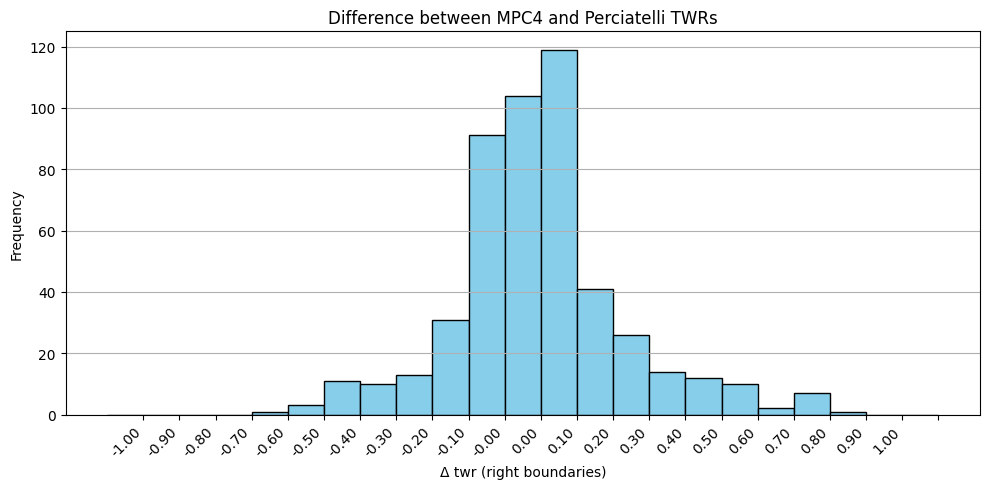

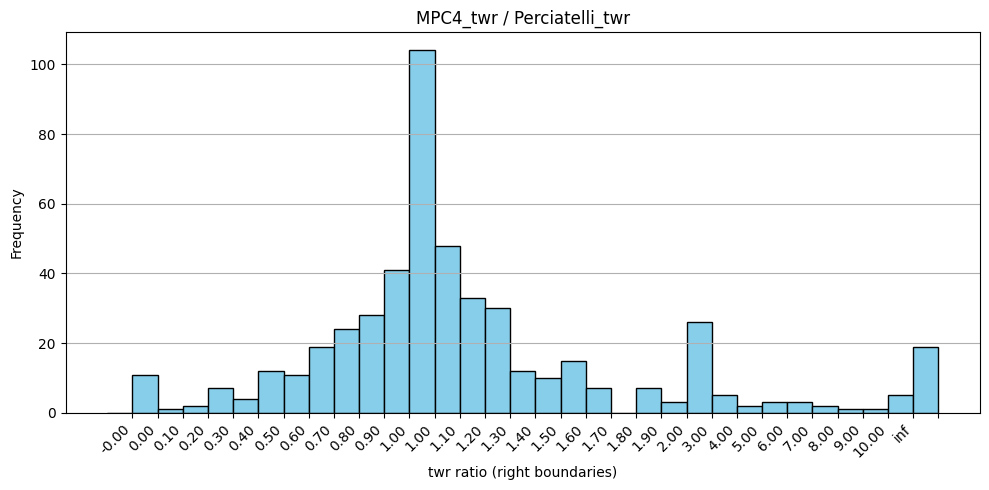

In [12]:
to_compare = ['MPC4Agent', 'Perciatelli44']

seeds, reports = get_metrics([ saved_results[saved_result_name] for saved_result_name in to_compare ])

delta_twr_num_buckets_one_side = 10
delta_twr_boundaries = np.concatenate([
    np.linspace(-1.0, 0.0, delta_twr_num_buckets_one_side + 1)[:-1],
    [-1e-8, 1e-8],
    np.linspace(0.0, 1.0, delta_twr_num_buckets_one_side + 1)[1:]])
fig = plt.figure()
delta_twr = reports[0].twr - reports[1].twr
histogram(delta_twr, delta_twr_boundaries)
plt.title('Difference between MPC4 and Perciatelli TWRs')
plt.xlabel('Δ twr (right boundaries)')
#plt.show()
plt.savefig('diffs.png')



def divide_scores(twr_a, twr_b):
    """ 
    special division for scores 
    
    if both are zero, return 1, but if a solution is found and the twr_b does not find it, this is infinity
    """
    return np.where(
        twr_b == 0.0,
        np.where(twr_a == 0.0, 1.0, np.inf),
        twr_a / twr_b
    )

twr_scores = divide_scores(reports[0].twr, reports[1].twr)

# Create more complicated boundary to handle ratios (special values at 0.0, 1.0, and inf)
num_buckets_lt_1 = 10
num_buckets_btwn_1_and_2 = 10
num_buckets_after_2 = 8
max_score_value_to_plot = 10
epsilon = 1e-8
twr_boundaries = np.concatenate([ [-epsilon, epsilon], 
    np.linspace(0.0, 1.0 - 1e-8, num_buckets_lt_1 + 1)[1:],
    np.linspace(1.0 + epsilon, 2.0, num_buckets_btwn_1_and_2 + 1),
    np.linspace(2.0, max_score_value_to_plot,num_buckets_after_2 + 1 )[1:],
    [np.inf]])

histogram(twr_scores, twr_boundaries)
plt.title('MPC4_twr / Perciatelli_twr')
plt.xlabel('twr ratio (right boundaries)')
#plt.show()
plt.savefig('ratios.png')